Background

Research Question

Methods

Result

Discussion


contribution

references

In [1]:
#from ensemble import RegressionEnsemble, MixedRegressionEnsemble, BootstrapEnsemble, ShuffleEnsemble
import ensemble
import importlib
importlib.reload(ensemble)

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression

# arrogant ignorance: A way to measure it

# smug predictors: How to bring them down

# identifying shitheads: Why it is important and how to do it

# Charlatans, dilletants, quacks - how to identify them Or my model keeps talking bullshit

We all know the situation: A discussion arises about some more or less important fact, and one of the discussors takes the lead by purporting to know everything about the situation and asserting a solution. A similar situation plays out 





\footnote{https://english.stackexchange.com/questions/288013/what-is-a-word-or-phrase-for-someone-who-professes-to-know-something-but-actuall}

## What is predictive uncertainty (Aleatoric and Epistemic Uncertainty)

[Predictive Uncertainty Estimation of
Hydrological Multi-Model Ensembles Using
Pair-Copula Construction] defines predictive uncertainty as follows:  'Predictive uncertainty (PU) is defined as the probability of occurrence of an observed variable of interest, conditional on all available information'. In other words, PU refers to the spread a predicted value is likely to exhibit given a model.
Classically, two kinds/sources of uncertainty have been identified: _Epistemic Uncertainty_, which arises from the model being uninformed or wrong and is successively often calles _model uncertainty_. As expected, this kind of uncertainty can theoretically be mended by obtaining more training data or changing the type of the model. (THIS IS WHAT THOMPSON SAMPLING IS ABOUT! WHERE DO WE FIND MORE DATA!)

_Aleatoric Uncertainty_, which arises from intrinsic uncertainty in the dataset. The reasons for this might be manifold, ranging from measurement errors to unobserved variables (that might otherwise be able to explain the spread better)\footnote{the philosophical discussion of whether an unobserved variable is in essence the reason for every aleatoric uncertainty, as could be argued by philosophical determinists is omitted for brevity}. A good example are two datapoints with close X values that differn significantly in y value - it is clear that a model will likely not be able to predict a value in between the two well. \footnote{this could, however, be alleviated by finding a new dimension of X that explains the difference between the two. Imagine two angler fish that are of the same age but vastly different size. While this might seem confusing, realising that male specimen are way smaller than their female counterparts gives the model a variable to distinguish the two by.}



[Predictive Uncertainty Estimation via Prior Networks] [DATASET SHIFT IN
MACHINE LEARNING] distinguish and additional level: Distributional uncertainty.

## What are we looking for?

Essentially a score that gives us an answer to the question 'is my model confident in situations where it's error tends to be low and uncertain when it's error is likely to be high?'. That would show us, how much we can trust the prediction it gives us - it this measure is unsatisfactory, we should consider switching the model (or possibly ensembling it with other models that have other strengths and weaknesses [cite]), gathering more data or generally reconsidering our approach (or just be really, really careful when making a decision).

## What does Uncertainty Callibration say?

"Calibration refers to the statistical consistency between the distributional forecasts and the observations and is a joint property of the predic- tions and the events that materialize" [Probabilistic forecasts, calibration and sharpness
Tilmann]

## What does Out of Distribution say?

### Formula

One of the more interesting scores we used is the 'average Negative Log Predictive Density', or NLPD for short. It is used in 
Quiñonero-Candela, J., Rasmussen, C. E., Sinz, F., Bousquet, O., & Schölkopf, B. (n.d.) to assess the quality of uncertainty of different models. 
In a gist, in the gaussian case, it's an average measure of how closely the predictive uncertainty matches the error, with a logarithmic penalty term for uncertainties.
$$ NLPD_i =  \frac{(\hat{y_i}- y_i)^2}{\sigma_i} + log(\sigma_i)  $$ where $\sigma_i$ is a samples predictive uncertainty, $\hat{y_i}$ is the samples predictive mean and $y_i$ is the samples real target value. 

The NLPD for the whole vector is computed as follows:

$$L = -\frac{1}{n}\sum_i^n log(p( y_i = t_i |x_i )$$
Which is simply the negative average of the above, taken over the whole Dataset

### Intuition
NLPD is characterised by two additive terms:   $\frac{(\hat{y_i}- y_i)^2}{\sigma_i}$ and $log(\sigma_i)$. The first term is a measure for _how closely the uncertainty of the model matches it's error_. This part scales linearly with the error, assuming the variance stays the same. Assuming the error is fixed and the variance changes, we get an approximately linear relationship where the variance is lower than the error and an approximaltely logarithmic relationship where the uncertainty is higher than the error. The first property comes from the negligible contribution of the second term (log(sigma)) compared to 1/v, with v<0; the second property comes from the negligible contribution of 1/v, v>0 compared to log(v). However, as we can see, the measure more heavily punishes overconfident models with a linear term, compared to a logarithmic term for under-confident models.


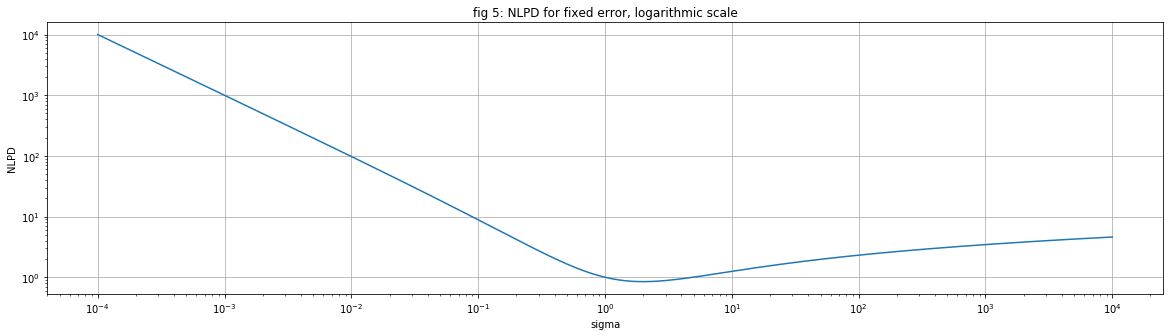

In [2]:
v = np.arange(0.0001,10000,.001)
e = np.arange(0,100,1000)
def nlpd_v(v):
    return 1/2 * np.log(v) + ((1)/v)
val_nlpd_v = nlpd_v(v)
plt.loglog(v,val_nlpd_v)
plt.xlabel('sigma')
plt.ylabel('NLPD')
plt.title('fig 5: NLPD for fixed error, logarithmic scale')
plt.grid(True)

Fig 5 displays the NLPD depending on $\sigma$ with a fixed value for $(\hat{y_i}- y_i)^2 = 1$. As we can see, it penalizes overconfident models (that display low uncertainty although they exhibit high error) more than underconfident (vice versa) ones. This opinion has its benefits and negative sides, but in general, it is an interesting measure of the quality of uncertainty.

### What it says

a NLPD score close to 0 indicates two things: The uncertainty of the model is in tune with the error and the uncertainty of the model is low. Indirectly this indicates that the error of the model itself has to be low (since this is the only way for $\sigma$ and the error to be in tune, which is necessary to keep the quotient value low, while also having a low $\sigma$ itself, which is necessary in order to obtain a low value for the logarithmic part of the equation. 

There are two sources of deviation from 0 in NLPD:
1. The model is not accurate ($\hat{y_i}- y_i)^2 >> 0$. This either results in a large quotient $(\hat{y_i}- y_i)^2/\sigma_i$ if $\sigma << (\hat{y_i}- y_i)^2$ or, if that quotient is low because the models predictive uncertainty is in tune with it's error ($\sigma \approx \hat{y_i}- y_i)^2$, OR in a large uncertainty (that might or might not be in tune with the error)

2. The model is accurate, but is underconfident ($\sigma >> \hat{y_i}- y_i)^2$). In this case the quotient is close to zero and the largest part of the score stems from the logarithmic part of the equation.



### What does convergence of NLPD say?


Assuming it converges towards 0: it means that the uncertainty matches the error and that the error goes towards 0. 




### is my model confident in situations where it knows the outcome and uncertain otherwise?

## What does a correlation between Error and Uncertainty express ecaxtly? 

### Formula
Is my model certain where it is correct and the other way round? 
More in detail: Pearson's Correlation Coefficient (following correlation) is computed by $$ r = \frac{\sum_i(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_i(x_i-\bar{x})^2}\sqrt{\sum_i(y_i-\bar{y})^2}}$$ Where $\bar{x_i}$ and $\bar{y}$ respectively denotes the mean of the variable and $x_i$ and $y_i$ denotes the ith entry in the dataset.\\
Essentially, the correlation between two variables tells us how co-related they are. 

### Intuition
IMPORTANT: Pearson's correlation is analogous to a normalised linear regression slope. (Note that the slope of a linear regression can be computed on-line\footnote{on a per-datapoint basis} with the formula y = ax + b where a = $a = \frac{\sum_i(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum_i(x_i-\bar{x})^2}}$ and $b = \bar{y} - a*\bar{x}$ with the same nomeclature as above, and thus correlation is in essence a centralised linear regression that is normalised additionally by the standard deviation of the target variable.

### What it says
Correlation is characterised as a quotient between two [things]: The Covariance of X and y regularized by the product of the variances or x and y.



In essence, the correlation between the error and the predictive uncertainty a model produces shows how well _one could be used to predict the other, assuming a linear relationship_. This is 


### What does the convergence of CoBEAU say?


### is my model confident in situations where it knows the outcome and uncertain otherwise?

### Can we use a walking correlation to estiate whether we have reached 'epistemic limits', or 'aleatoric uncertainty measures'? Then theoretically check the errors for normalcy and then decide if the current model is satisfactory or not//What does Convergence of this say?

Calculating the walking correlation of predictor and target 



https://stats.stackexchange.com/questions/23481/are-there-algorithms-for-computing-running-linear-or-logistic-regression-param

We all know the situation: A discussion starts, and one of the [mitmachern] is sure to be right, while other express uncertainty on the topic. In solcial situations, this can 

- Decision making often relies on convincing others
- In order to be convincing it often happens that the person who is the most sure takes the win. This is a big problem in science communication: Scientists always confer uncertainty and never commit to an absolute statement. Politicians do - this convinces masses
- we have a similar issue when relying on Machine Learning to give us an advice on how to proceed
- This is being used in reinforcement learning (example: Thompson sampling where the optimal solution is sampled from the probability of it being correct via some spread-function)
- What we need is a way to discern if an agent certain in situations in which he tends to be correct and uncertain in situations where he tends to be incorrect
- Aleatoric vs Epistemic uncertainty - it is impportant to be aware if the agent doesn't know things because he hasn't seen enough data or if the agent is too close minded - I.e. wrong model
- a few measures can be applied to this problem: Callibration (Frequentist, does the long term model uncertainty converge towards the data uncertainty), Out of Distribution Samples (Does the model report high uncertainty for situation in which it cannot be very knowledgeable, such as a cat species classifier asked to classify a camel)
- one particularly interesting measure is NLPD.
- one more interesting measure that to the best knowledge of the author hasn't been utilised is the correlation between error and uncertainty

Classification vs Regression

While this topic has been researched for classification a little better (see cites!), in regression there seems to be little interest in the topic of identifying shitheads

What uncertainty are we looking at - certainty that the predictive mean is somewhere close to the prediction OR Data uncertainty?

Aleatoric vs Epistemic:


Callibration

Out of sample

Now we're getting somewhere. This measure expresses the behaviour of an agent when he is confronted with unknown data. The classical case is an image classifier who gets presented with something he wasn't trained to recognize - a cat species classifier being shown a camel, for example.

NLPD
This measure is very interesting. 
Conservative (prefers underconfident over overconfident)
depends on uncertainty scaling


Correlation between uncertainty and error

This measure only takes into account LINEAR relations

THUS A CORRELATION IS ALREADY A MODEL SPECIFICATION?!? THAT IS NOMRALISED

## Methods

to compare NLPD and Correlation between error and uncertainty (EUC? CEU? CoBEAU (COrellation Between Error and Uncertainty), the measures have been applied to two Data Sets: A  one dimensional, linear Toy Dataset created via the Scikit Learn make_regression and the multi dimensional non linear Boston Housing Dataset from [Cite]. 

The first set has been chosen for it's simplicity as well as the fact that it is easy to visualise, aiding the [aufbau] of intuition for the difference between NLDP and CoBEAU, while the second Dataset has been chosen in order to analyse real-life performance of both measures.

We are going to look at the behaviour of both measures when confronted with each dataset and from there try to explain general and distinguishing properties of the measures.

Additionally, some visualisation and mathematical properties are analysed to gain insights into performance and optimal application of each of the statistics. 









## plot both as functions of error and variance

Both measures depend on the vector of predictive uncertainty and the error produced by the model.

To gain an intuition of how each variable impacts the measurements, some plots:
First what we can see is that it is possible to plot NLPD on a fixed error and get 

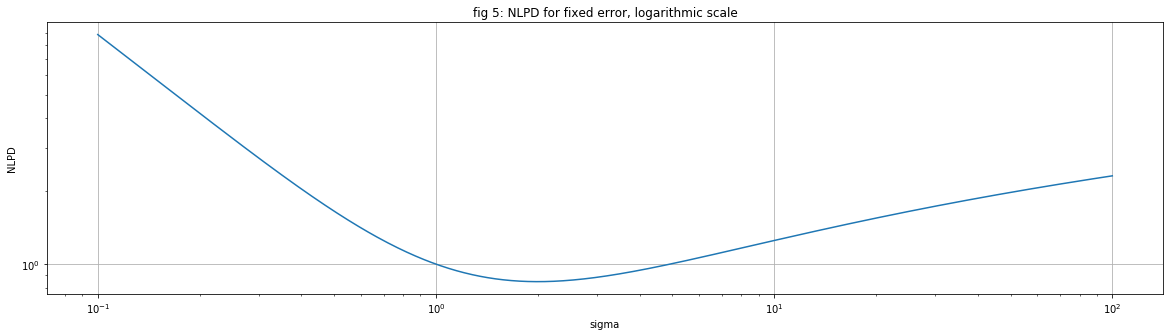

In [3]:
import numpy as np

v = np.arange(0.1,100,.01)

def nlpd_v(v):
    return 1/2 * np.log(v) + ((1)/v)


val_nlpd_v = nlpd_v(v)
plt.loglog(v,val_nlpd_v)
plt.xlabel('sigma')
plt.ylabel('NLPD')
plt.title('fig 5: NLPD for fixed error, logarithmic scale')
plt.grid(True)



In [4]:
def nlpd_e(e):
    return 1/2 * np.log(1) + ((e)/1)

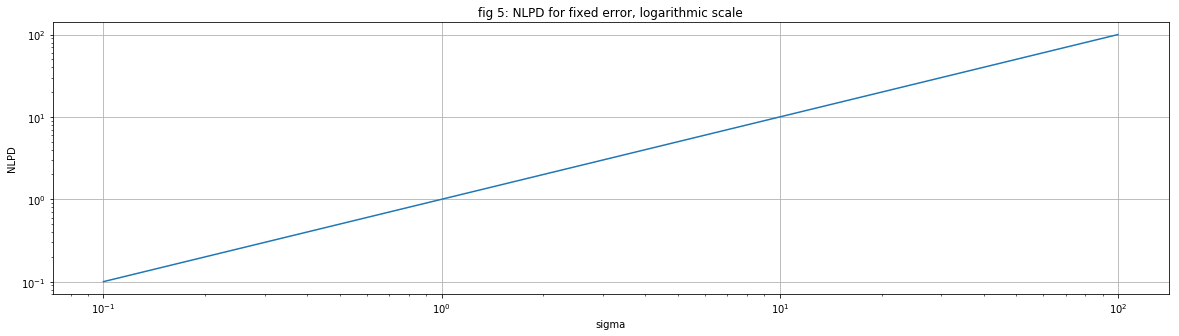

In [5]:
e = np.arange(0,100,.1)



val_nlpd_e = nlpd_e(e)
plt.loglog(e,val_nlpd_e)
plt.xlabel('sigma')
plt.ylabel('NLPD')
plt.title('fig 5: NLPD for fixed error, logarithmic scale')
plt.grid(True)


# What models to use
Ensemble mixed models

Ensemble Bootstrap

Ensemble Forest (as bad example)

Gaussian Process (If possible)

Direct estimation of data noise (does that make sense)

# Discussion

## Is my model aware of it's shortcomings

Yes, those measures are quire effective at finding out if a model generates valud predictive uncertainty.

They are SOMEWHAT similar, both being normalised at least by one kind of standard deviation, one being computed from the covariance of the two variables while the other is being computed by the error; 

## Differences

### opinionated
NLPD is opinionated

### data scale is important!
NLPD depends on the scale of the data :/

### penalizes 0 uncertainty infinitely
NLPD penalizes 0 uncertainty with infinity. As [Evaluating Predictive Uncertainty Challenge] mentions, this might be seen as too harsh; however, given that a properly bayesian agent should never assign perfect certainty (which corresponds to the degenerate gaussian in this case) to anything. In out example, in order to conserve numerical stability, a small minimal value was assigned to sigma.

### implicit modelling of callibration
NLPD implicitly models the callibration of the uncertainty estimates of the model locally. While it still holds true that a model can be well calibrated without giving good NLPD scores (as callibration does not factorize locality of the predictive uncertainty - a well calibrated model can exhibit uncertainty in the _wrong places_, a good NLPD score implicitly indicates good callibration (since it is impossible to get a NLPD score close to 0 for a model who's error (Which is used to compute the noise of the data) systematically deviates from its predictive uncertainty). 

### dependency on scale of error
NLPD depends on the size of the error - thus it will always penalize models that exhibit _epistemic uncertainty_ - uncertainty in the face of a large error will be penalized less than overconfidence but it will nonetheless be penalized.

CoBEAU generally only cares of the DIRECTION of the error - not it's scale

### dependency on scale of Uncerainty

NLPD depends heavily on the scale of the uncertainty. 

CoBEAU does not depend on the scale of the uncertainty - only it's direction

## How do they realte to each other

If NLPD is low, meaning that error and uncertainty are well aligned (and both are relatively low), we can assume that the CoBEAU score is close to 1, since each error is accompanied by a similar value of predictive uncertainty, which guarantees that they correlate to a certain extend.

However, a CoBEAU score close to 1 does not necessarily warrant a low NLPD - it is conceivable that either the uncertainty is badly scaled or the error is high, which would not interfere with correlation between uncertainty and error but would lead to a high NLPD score. In this case, we can deduce that our model is well attuned in that it is aware of it's error (uncertainty is relatively high where the error is relatively high), but it is either over or under confident. 

Overconfident: In this case, the model reports uncertainty that is generally too low. Several possible causes can be identified

Underconfident

### quotient of CoBEAU and NLPD

If the NLPD is high and CoBEAU is close to 1, we can assume that the model is generally well attuned with regards to predictive uncertainty and error - however, it is likely that the scaling of the predictive uncertainty is suboptimal. This can have several reasons: a) bad computation of the uncertainty. This could e.g. happen in a situation where an ensemble of models is being used. it would point towards either too much correlation in the ensemble members (leading to a degenerate ditribution/ distribution that is computed from too similar samples) OR b) the influence of a badly performant model; which would lead to a large discrepancy between predictions (take the extreme case of a linear regression being contained in an ensemble for a highly non-linear dataset, see Figure [X]).


In [16]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y =  np.sin(X).ravel()*10 + np.random.normal(0,1,size=X.shape[0])
#y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
forest_regression = ensemble.RegressionEnsemble()
forest_regression.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis] 
y_forest,std_forest = forest_regression.predict(X_test,std=True)



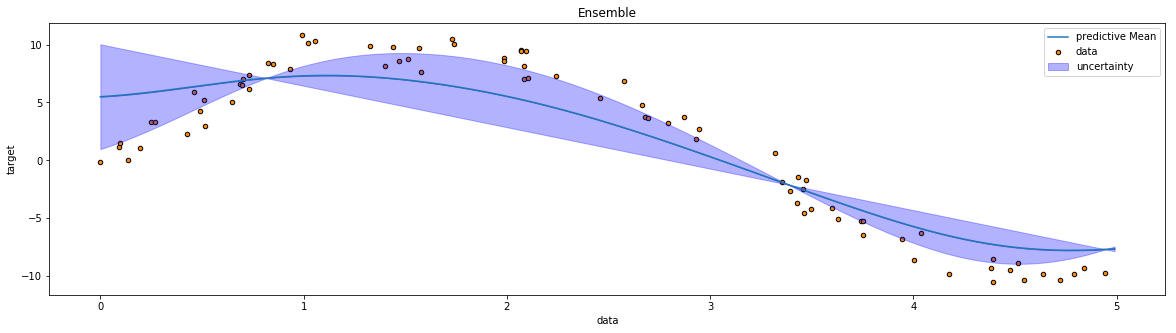

In [17]:
mixed_ensemble_2 = ensemble.MixedRegressionEnsemble(models = [#DecisionTreeRegressor(),
                                                            LinearRegression(),
                                                            #KNeighborsRegressor(),
                                                            #MLPRegressor(max_iter=1000),
                                                           SVR()
                                                             ])
mixed_regression = mixed_ensemble_2#DecisionTreeRegressor(max_depth=5)
mixed_regression.fit(X, y)
y_mixed,std_mixed = mixed_ensemble_2.predict(X_test,std=True)

mixed_ensemble_2.scatterplot(X_test,X=X,y=y)

In [18]:
mixed_ensemble_2.self_evaluate(X,y)

{'NLPD': -7.816971229285038,
 'correlation between error and variance': 0.7142195358917369,
 'coverage probability': 0.3,
 'rsme': 2.5158578613432403}

/Users/thomas/anaconda/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


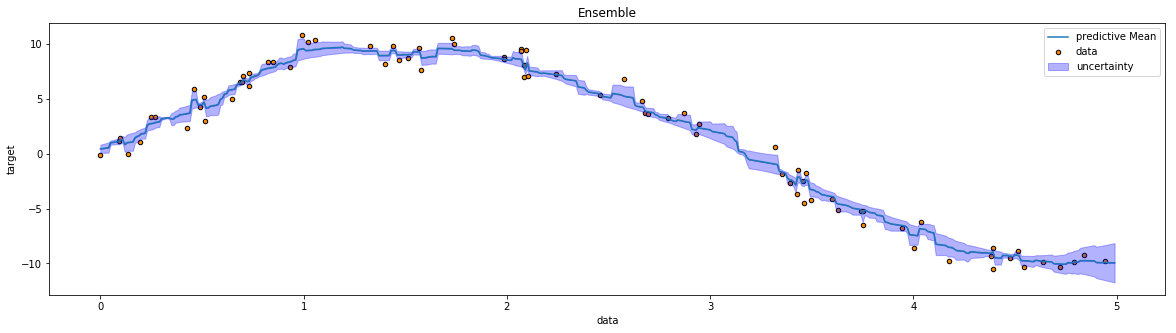

In [19]:
mixed_ensemble = ensemble.MixedRegressionEnsemble(models = [DecisionTreeRegressor(),
                                                            #LinearRegression(),
                                                            KNeighborsRegressor(),
                                                            MLPRegressor(max_iter=1000),
                                                           SVR(),
                                                           RandomForestRegressor()])
mixed_regression = mixed_ensemble#DecisionTreeRegressor(max_depth=5)
mixed_regression.fit(X, y)
y_mixed,std_mixed = mixed_regression.predict(X_test,std=True)

mixed_ensemble.scatterplot(X_test,X=X,y=y)

In [20]:
mixed_ensemble.self_evaluate(X,y)

{'NLPD': 0.012107729652504295,
 'correlation between error and variance': 0.5325397848011794,
 'coverage probability': 0.4,
 'rsme': 0.6779765264361106}

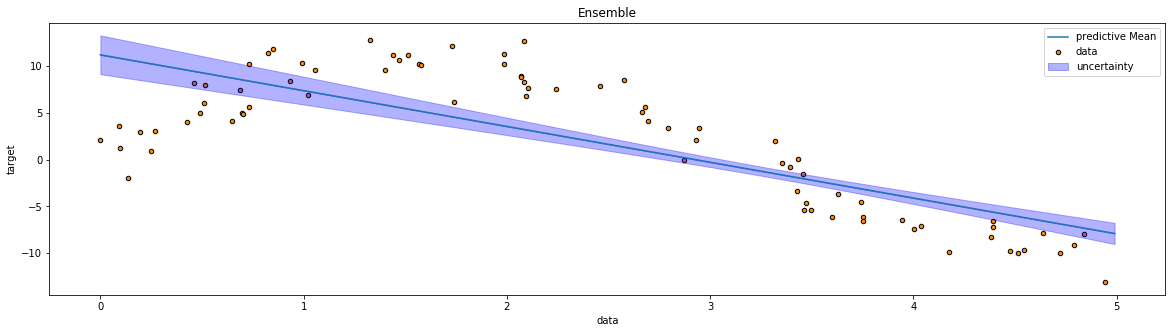

In [11]:
bootstrap_linear = ensemble.BootstrapEnsemble(model_type=LinearRegression ,num_models=25)
                                 
bootstrap_regression = bootstrap_linear#DecisionTreeRegressor(max_depth=5)
bootstrap_regression.fit(X, y)
y_mixed,std_mixed = bootstrap_regression.predict(X_test,std=True)

bootstrap_regression.scatterplot(X_test,X=X,y=y)

In [12]:
bootstrap_regression.self_evaluate(X,y)

{'NLPD': -9.82476262486144,
 'correlation between error and variance': 0.42724536184884165,
 'coverage probability': 0.1,
 'rsme': 4.655282451348589}


## When to use each score
The choice when to use which score comes down to a couple of decisions. 

NLPD is very opninionated when it comes to over- vs undercondifrnt models. It also depends strongly on the scale of the predictive uncertainty.

CoBEAU is not opinionated, it only reports co-occuring deviation from the mean of both error and uncertainty

### NLPD
Opinionated: prefers underconfident models over overconfident ones


### Practical Example: Thompson Sampling

One of the more intriguing applications of predictive uncertainty is in the domain of reinforcement learning, more specifically in the realm of Multi-Armed-Bandit problems. In these situations\footnote{Named after the slot machines usually seen in casinos or similar establishments}, the agent has to choose between several possible choices (the _arms_) that compete for a limited amount of resources while optimising her expected reward. The problem arises from the fact that the coices are not thoroughly explored and thus the agent has to make a decision between _exploration and exploitation_ at each step [cite Bandit problems]. Thompson sampling, which in general is the idea of playing each arm according to its probability of being the optimal choice, has been proven to be within optimal bounds of regret\footnote{briefly: A measure of 'how much better I could have performed had I known which arm is the optimal arm'} in [Analysis of Thompson Sampling for the Multi-armed Bandit Problem]. \\
In practice, Thompson sampling\footnote{The algorithm can range from very simple bernoulli distrbutions to any kind of complex model that offers a distribution to be samples from through some (in the authors opinion) very smart manipulations of the vector of predicting variables.} relies on being able to sample from a distribution of possible outcomes for each arm (where the draws from the distributions are compared to factor in the probability of being optimal).\\
[put in definition from Wikipedia that shows dependence on posterior distribution].
Obviously, the Thompson Sample depends heavily on the availability of a model that gives predictions that converge towards being 'aware of their own uncertainty', since this is where it facilitates exploration vs exploitation.
 
is a problem in which a fixed limited set of resources must be allocated between competing (alternative) choices in a way that maximizes their expected gain, when each choice's properties are only partially known at the time of allocation, and may become better understood as time passes or by allocating resources to the choice.

## Combination of CoBEAU and NLDP

What does it say if they are pointing in the same direction?

What does it say if they are pointing in different directions?

